# Step 2: Exploratory Data Analysis (EDA)

In this step I explored the chosen dataset, created a baseline model, and explored how transforming the data affects our training.

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

# Setup: Loading images.

## Data

The database used here is the [Flowers-299](https://www.kaggle.com/datasets/bogdancretu/flower299/) kaggle dataset.

 * 299 classes of flowers
 * ~200-400 images per class
 * 116,000 images total
 * Obtained with a web crawler through google image search


To run this notebook start by downloading the zip and then extract the files to a folder called "images".

**Note: cleaning of labels.**

When reading the data I got an error like this: `'utf-8' codec can't decode byte 0x93 in position 53:`. This was happening because the labels contain a Turkish character inplace of apostrophe's. For example a label might be called `BabyΓÇÖsBreath`. To fix this I went through and removed these characters from the folder names.

In [4]:
import pathlib
import os.path

data_dir =  pathlib.Path(os.path.abspath("images/Flowers15/"))
data_dir

WindowsPath('E:/school/UCSD-ML-Capstone/images/Flowers15')


## Switching from Pandas Dataframe to TensorFlow Dataset
In the previous notebook I loaded the images into a pandas dataframe. However that led to a lot of memory issues. For example, when transforming the images to an input I would end up with a duplicate set of images. To solve the problem I have switched to using a [tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) instead. This way my code will only load a batch of images from disk as they are needed, and then clear it from memory.


In [5]:
batch_size = 32
epochs=15
img_height = 180
img_width = 180

In [6]:
train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split=0.2, subset="both", seed=123,
                                                               image_size=(img_height, img_width), batch_size=batch_size)

Found 5902 files belonging to 15 classes.
Using 4722 files for training.
Using 1180 files for validation.


In [5]:
class_names = train_ds.class_names
print(class_names)

['Abutilon', "Baby'sBreath", 'Calceolaria', 'Celosia', 'Daffodil', 'Epimedium', 'Erica', 'FrangipaniFlower', 'Freesia', 'FrenchMarigold', 'Hibiscus', 'Hyacinth', 'IpomoeaLobata', 'Iris', 'JohnnyJumpUp']


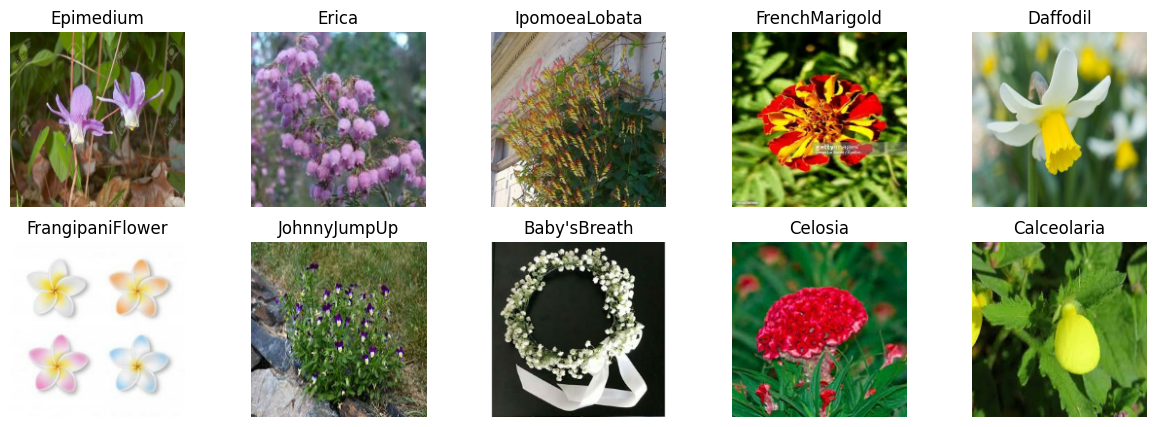

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
num_classes = len(class_names)
num_classes

15

# Establishing a baseline.

Here I run a simple Convolutional Neural Network(CNN) on the unaltered data to see how it performs. This will give us a way measure how our data transformations will affect our training.

In [8]:
# Defining a function so we can re-use the same type of model,
# but without inheriting the training of the previous model. That is, copies rather than references.
def base_model_layers():
    return [
        layers.Rescaling(1./255),
        layers.Conv2D(16, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(),
        layers.Dropout(0.2),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes),
    ]
model = tf.keras.Sequential(base_model_layers())

model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [9]:
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
148/148 [==============================] - 72s 478ms/step - loss: 2.1758 - accuracy: 0.2846 - val_loss: 1.7881 - val_accuracy: 0.4161
Epoch 2/15
148/148 [==============================] - 53s 356ms/step - loss: 1.4957 - accuracy: 0.5280 - val_loss: 1.5098 - val_accuracy: 0.5195
Epoch 3/15
148/148 [==============================] - 57s 384ms/step - loss: 0.9698 - accuracy: 0.7033 - val_loss: 1.3433 - val_accuracy: 0.5958
Epoch 4/15
148/148 [==============================] - 57s 381ms/step - loss: 0.5292 - accuracy: 0.8424 - val_loss: 1.0934 - val_accuracy: 0.7229
Epoch 5/15
148/148 [==============================] - 58s 390ms/step - loss: 0.2847 - accuracy: 0.9140 - val_loss: 1.1666 - val_accuracy: 0.7331
Epoch 6/15
148/148 [==============================] - 54s 362ms/step - loss: 0.1306 - accuracy: 0.9646 - val_loss: 1.1662 - val_accuracy: 0.7873
Epoch 7/15
148/148 [==============================] - 56s 378ms/step - loss: 0.1018 - accuracy: 0.9706 - val_loss: 1.3529 - val_ac

In [10]:
def plot_history(history, title):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

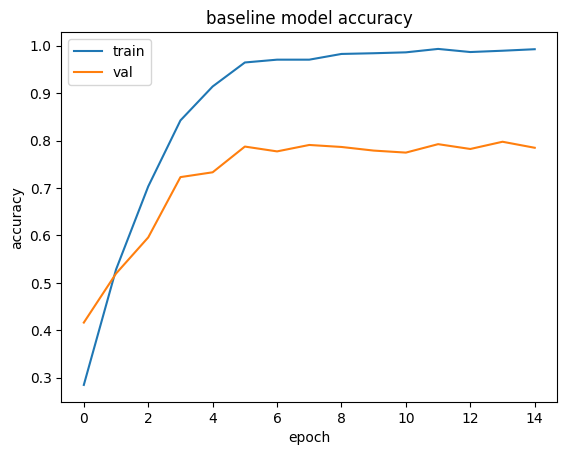

In [11]:
plot_history(history, 'baseline model accuracy')
plt.show()

# Evaluating class imbalance

In [12]:
import numpy as np
y_pred = []  # store predicted labels
y_true = []  # store true labels

# Calculate the confusion matrix.
# We iterate over the dataset to get the true label and input at the same time.
# Otherwise we will unintentionally shuffle the dataset.
for image_batch, label_batch in val_ds:
   y_true.append(label_batch)
   preds = model.predict(image_batch, verbose=0)
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(correct_labels, predicted_labels)

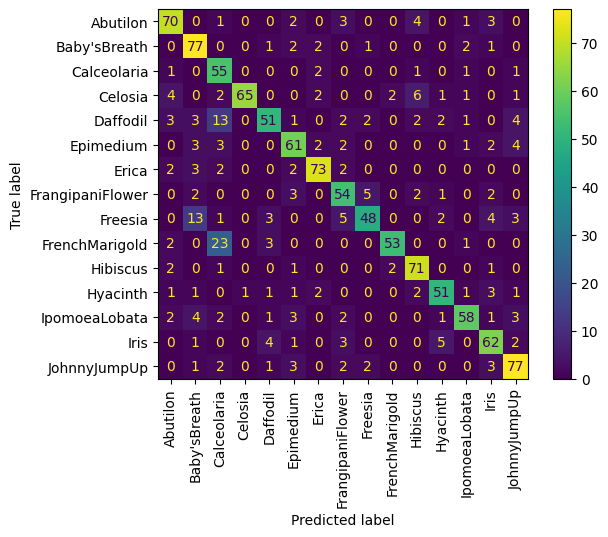

In [14]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_ds.class_names)
disp.plot(xticks_rotation='vertical')

Our data does not seem to be imbalanced, and our predictor seems to work well for each class type. It looks like we don't need to worry about this. This is also what we would expect from the dataset description, classes typically have ~200-400 images each.

# Trying data augmentation

Data augmentation is a technique where you generate more training samples by modifying the images, for example by rotating them or flipping them. Let's try it to see if it can improve our training by artificially generating more samples.

In [15]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])
model2 = tf.keras.Sequential([data_augmentation] + base_model_layers())

model2.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [16]:
history2 = model2.fit(train_ds, validation_data=val_ds, epochs=epochs)

Epoch 1/15
148/148 [==============================] - 82s 546ms/step - loss: 2.1819 - accuracy: 0.2812 - val_loss: 1.8704 - val_accuracy: 0.3924
Epoch 2/15
148/148 [==============================] - 84s 567ms/step - loss: 1.7278 - accuracy: 0.4384 - val_loss: 1.6916 - val_accuracy: 0.4475
Epoch 3/15
148/148 [==============================] - 82s 555ms/step - loss: 1.5135 - accuracy: 0.5133 - val_loss: 1.5576 - val_accuracy: 0.4932
Epoch 4/15
148/148 [==============================] - 82s 555ms/step - loss: 1.3907 - accuracy: 0.5517 - val_loss: 1.4082 - val_accuracy: 0.5432
Epoch 5/15
148/148 [==============================] - 82s 554ms/step - loss: 1.2674 - accuracy: 0.5906 - val_loss: 1.2933 - val_accuracy: 0.5907
Epoch 6/15
148/148 [==============================] - 73s 491ms/step - loss: 1.1582 - accuracy: 0.6341 - val_loss: 1.1735 - val_accuracy: 0.6305
Epoch 7/15
148/148 [==============================] - 76s 513ms/step - loss: 1.0796 - accuracy: 0.6476 - val_loss: 1.2279 - val_ac

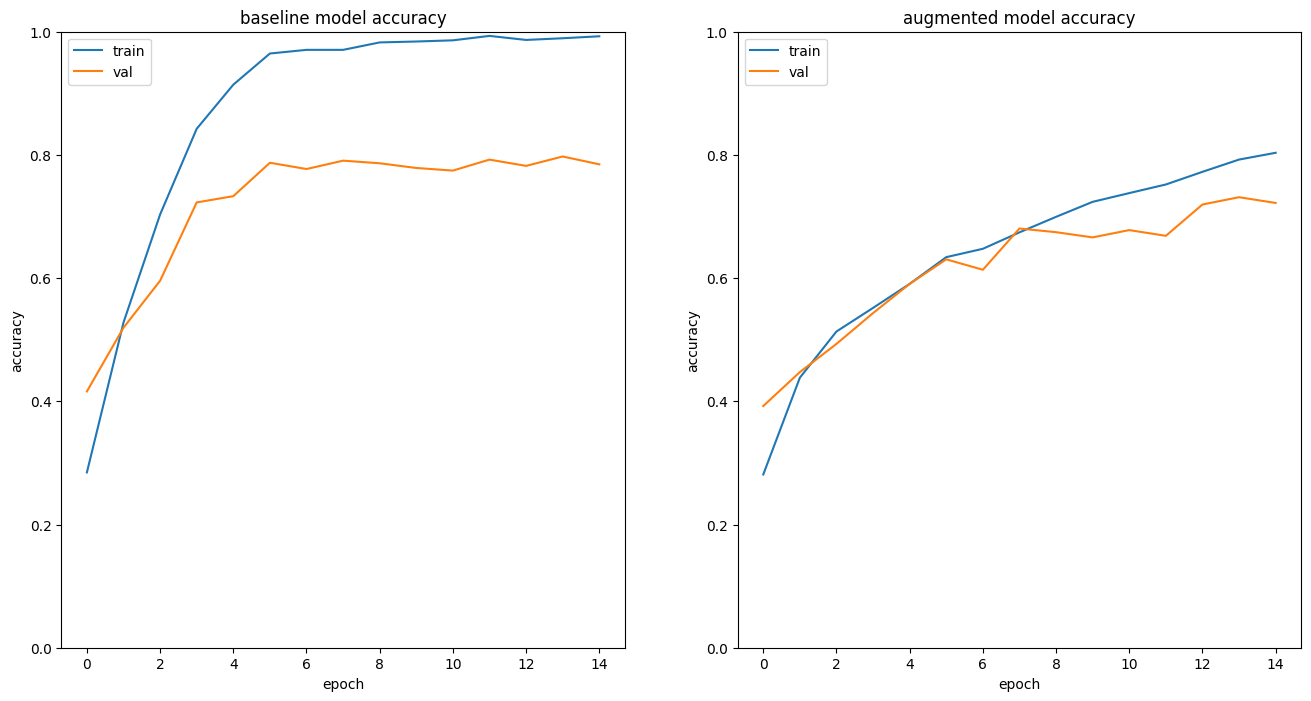

In [17]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1, ylim=(0, 1))
plot_history(history, 'baseline model accuracy')
plt.subplot(1, 2, 2, ylim=(0, 1))
plot_history(history2, 'augmented model accuracy')
plt.show()

Augmenting the data seems to be an effective way to remove bias from our model, however it also seems to slow down our training rate, so we now require more epochs to train.

## Addendum: Synonym classes

In Step #9 when working on scaling to the full dataset I noticed there are some flowers that show up both as their common name and their scientific name.

Below is debugging output from the confusion matrix (299x299 rows were too large to plot). It shows the number of wrong predictions and the true/predicted class.

```
(r, c): (3, 206) val= **21 AfricanDaisy Osteospermum**
(r, c): (13, 144) val= 18 AniseHyssop Hyssop
(r, c): (15, 38) val= 14 Aster Brachyscome
(r, c): (15, 60) val= 12 Aster Chrysanthemum
(r, c): (21, 24) val= 15 BeeBalm Bergamot
(r, c): (28, 121) val= **54 BlanketFlower Gaillardia**
(r, c): (54, 218) val= 13 Catharanthus Periwinkle
(r, c): (69, 18) val= 13 Cornflower Bachelor'sButton
(r, c): (74, 106) val= 13 Crocus FallCrocus
(r, c): (79, 60) val= 11 Dahlia Chrysanthemum
(r, c): (80, 179) val= 10 Daisy MargueriteDaisy
(r, c): (80, 208) val= 11 Daisy OxeyeDaisy
(r, c): (97, 17) val= 10 Elder Baby'sBreath
(r, c): (101, 131) val= 14 Erica Heather
(r, c): (119, 180) val= 15 FrenchMarigold Marigold
(r, c): (131, 101) val= 15 Heather Erica
(r, c): (154, 275) val= 14 JohnnyJumpUp Viola
(r, c): (169, 202) val= 12 Lily OrientalLily
(r, c): (190, 78) val= **28 Narcissus Daffodil**
(r, c): (202, 169) val= 13 OrientalLily Lily
(r, c): (206, 3) val= 11 Osteospermum AfricanDaisy
(r, c): (211, 275) val= 16 Pansy Viola
(r, c): (218, 54) val= 14 Periwinkle Catharanthus
(r, c): (228, 203) val= 14 Poppy OrientalPoppy
(r, c): (246, 208) val= 15 ShastaDaisy OxeyeDaisy
(r, c): (282, 68) val= 10 Wedelia Coreopsis
```

We can see that AfricanDaisy shows up as twice in our classes, and so does daffodils and blanket flowers.

To fix this I went and created a new dataset where duplicates were removed.